### Datadownload

In [73]:

download_path = 'https://www.kaggle.com/alxmamaev/flowers-recognition/download'


In [16]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

### Preparing data

In [37]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='./data/flowers/flowers/daisy'
FLOWER_SUNFLOWER_DIR='./data/flowers/flowers/sunflower'
FLOWER_TULIP_DIR='./data/flowers/flowers/tulip'
FLOWER_DANDI_DIR='./data/flowers/flowers/dandelion'
FLOWER_ROSE_DIR='./data/flowers/flowers/rose'

In [38]:
def assign_label(img,flower_type):
    return flower_type


In [39]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        try:
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            Z.append(str(label))
        except Exception as e:
            print(e)

In [40]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 769/769 [00:03<00:00, 239.16it/s]

769


In [41]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 734/734 [00:04<00:00, 172.03it/s]

1503


In [42]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))


100%|██████████| 984/984 [00:05<00:00, 189.42it/s]

2487


In [43]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))


  2%|▏         | 17/1056 [00:00<00:06, 166.84it/s]

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



100%|██████████| 1056/1056 [00:05<00:00, 202.12it/s]

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

3539


In [44]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:03<00:00, 212.89it/s]

4323


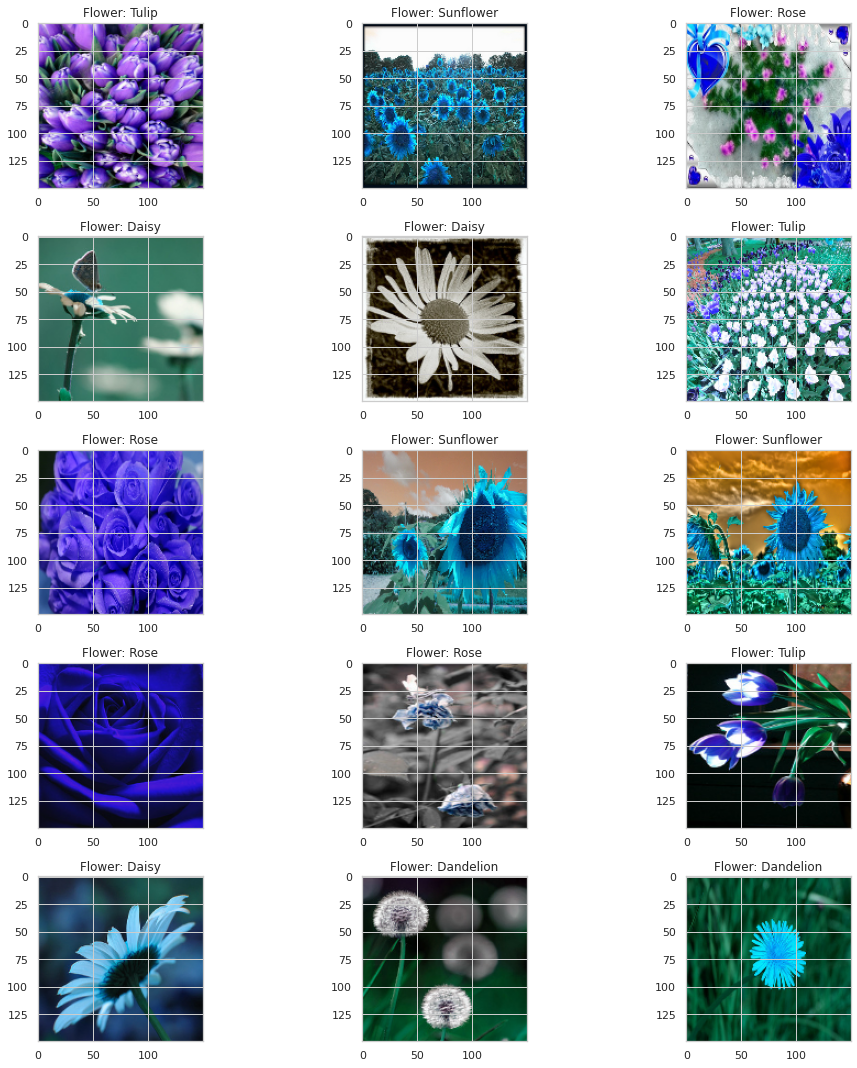

In [46]:
fig,ax=plt.subplots(5,3)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (3):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

### Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [47]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

### Splitting into Training and Validation Sets

In [49]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

### Set the random seed

In [55]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

###  Building the ConvNet Model

In [57]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

### Using learning rate decay

In [64]:
epochs=50
batch_size=128
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

### Data augmentation using datagen in TF

In [59]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

### Model summary 

In [61]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 18, 96)       

### Fitting on the Training set and making predcitons on the Validation set

In [65]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
25/25 [==============================] - 86s 3s/step - loss: 1.6273 - accuracy: 0.2537 - val_loss: 1.3892 - val_accuracy: 0.3571
Epoch 2/50
25/25 [==============================] - 148s 6s/step - loss: 1.2978 - accuracy: 0.4136 - val_loss: 1.3144 - val_accuracy: 0.4144
Epoch 3/50
25/25 [==============================] - 151s 6s/step - loss: 1.1736 - accuracy: 0.4939 - val_loss: 1.2003 - val_accuracy: 0.5227
Epoch 4/50
25/25 [==============================] - 131s 5s/step - loss: 1.0997 - accuracy: 0.5536 - val_loss: 1.0176 - val_accuracy: 0.5948
Epoch 5/50
25/25 [==============================] - 99s 4s/step - loss: 1.0200 - accuracy: 0.5951 - val_loss: 0.9973 - val_accuracy: 0.5846
Epoch 6/50
25/25 [==============================] - 104s 4s/step - loss: 0.9717 - accuracy: 0.6362 - val_loss: 0.9354 - val_accuracy: 0.6189
Epoch 7/50
25/25 [==============================] - 86s 3s/step - loss: 0.9062 -

### Evaluating the Model Performance

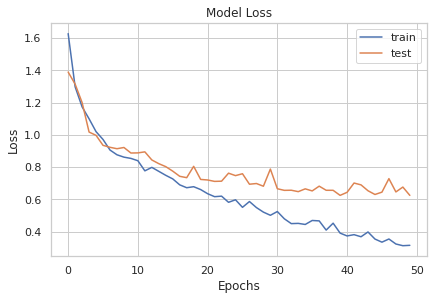

In [66]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

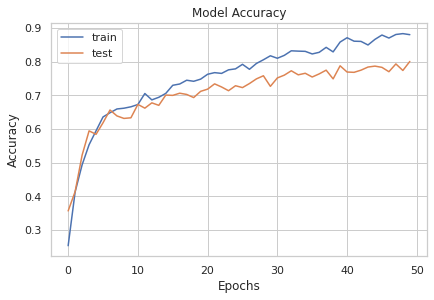

In [70]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()